In [ ]:
# import the libraries

In [ ]:
conda install py-xgboost

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier
import time
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import roc_curve, auc
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree 
import itertools

In [2]:
df = pd.read_csv('final_dataframe.csv',index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1646 entries, 0 to 1670
Data columns (total 16 columns):
ISBN                  1646 non-null int64
title                 1646 non-null object
series                1646 non-null int64
author                1646 non-null object
rating                1646 non-null float64
genre                 1646 non-null object
publish_date          1645 non-null object
publish_company       1637 non-null object
format                1645 non-null object
number_of_pages       1646 non-null int64
publish_month         1646 non-null object
publish_year          1646 non-null int64
NYT_bestseller        1646 non-null float64
length_of_title       1646 non-null int64
num_words_in_title    1646 non-null int64
top_authors           1646 non-null int64
dtypes: float64(2), int64(7), object(7)
memory usage: 218.6+ KB


# Set up for modeling

In [4]:
feats = ['series','rating','publish_month','length_of_title',
         'publish_company','genre','num_words_in_title','top_authors']

X = pd.get_dummies(df[feats], drop_first=True)

In [5]:
# for publisher, genre, and month of publishing, i only want the "important ones"
# which i have deemed to be anything where the count was over 10 

X.drop([col for col, val in X.sum().iteritems() if val < 10], axis=1, inplace=True)

In [6]:
X.columns

Index(['series', 'rating', 'length_of_title', 'num_words_in_title',
       'top_authors', 'publish_month_August', 'publish_month_December',
       'publish_month_February', 'publish_month_January', 'publish_month_July',
       'publish_month_June', 'publish_month_March', 'publish_month_May',
       'publish_month_November', 'publish_month_October',
       'publish_month_September', 'publish_company_Hachette',
       'publish_company_Harper Collins',
       'publish_company_Houghton Mifflin Harcourt',
       'publish_company_Macmillan', 'publish_company_Penguin Random House',
       'publish_company_Simon & Schuster', 'genre_autobiography',
       'genre_biography', 'genre_childrens', 'genre_contemporary',
       'genre_fantasy', 'genre_fiction', 'genre_food-and-drink',
       'genre_historical', 'genre_history', 'genre_horror',
       'genre_media-tie-in', 'genre_mystery', 'genre_non-fiction',
       'genre_poetry', 'genre_politics', 'genre_romance',
       'genre_science-fiction', 'ge

In [7]:
# Y is the target variable
Y = df['NYT_bestseller']

In [8]:
X.head()

,series,rating,length_of_title,num_words_in_title,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,...,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_sports-and-games,genre_thriller,genre_young-adult
0,0,4.17,57,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,4.11,63,12,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,4.09,11,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,4.16,47,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,4.08,68,13,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [9]:
# normalize the features

for col in X.columns:
    X[col] = (X[col]-min(X[col]))/ (max(X[col]) - min(X[col])) 

#We subtract the minimum and divide by the range forcing a scale of 0 to 1 for each feature

X.head()

,series,rating,length_of_title,num_words_in_title,top_authors,publish_month_August,publish_month_December,publish_month_February,publish_month_January,publish_month_July,...,genre_non-fiction,genre_poetry,genre_politics,genre_romance,genre_science-fiction,genre_sequential-art,genre_short-stories,genre_sports-and-games,genre_thriller,genre_young-adult
0,0.0,0.624434,0.295082,0.235294,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.597285,0.327869,0.323529,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.588235,0.043716,0.029412,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.619910,0.240437,0.235294,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.583710,0.355191,0.352941,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

# Baseline: 

In [11]:
df['NYT_bestseller'].value_counts(normalize=True)

0.0    0.665249
1.0    0.334751
Name: NYT_bestseller, dtype: float64

In [53]:
dum_clf = DummyClassifier(strategy='most_frequent')
dum_model = dum_clf.fit(X_train,y_train)
y_hat_train = dum_clf.predict(X_train)
y_hat_test = dum_model.predict(X_test)

In [56]:
print(accuracy_score(y_hat_train,y_train))
print(accuracy_score(y_hat_test,y_test))

0.6671732522796353
0.6575757575757576


In [ ]:
# i need my model to perform better than 65.75%!

In [ ]:
# for this specific classification problem, I have focused on increasing accuracy and F1 given that 
# i believe a false positive and false negative are equally "bad" and 
# FP = not really a best seller, but my model said it was (wasted investment)
# FN = a best seller but my model said it wasn't (missed business opportunity)
# my goal should be to make the most accurate model possible

## Helper Functions

In [16]:
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))

In [42]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Pseudocode/Outline:
    #Print the confusion matrix (optional)
    #Create the basic matrix.
    #Add title and Axis Labels
    #Add appropriate Axis Scales
    #Add Labels to Each Cell
    #Add a Side Bar Legend Showing Colors
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
def plot_AUC_ROC(y_score,fpr,tpr):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    print('AUC: {}'.format(auc(fpr, tpr)))
    plt.figure(figsize=(10,8))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [49]:
def plot_feature_importance(model, x_train, n=30):
    # extract and sort the feature importance
    features = model.feature_importances_
    columns = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, columns])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
     # plot the features
    plt.figure(figsize=(16, 12))
    try:
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    
    except:
        # if n features is greater than the amount that actually exists
        n = len(sorted_feat)
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
        
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

# Model 1: Logistic Regression

In [19]:
logreg = LogisticRegression(fit_intercept = False, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [ ]:
# Inverse regularization parameter - A control variable that retains strength 
# modification of Regularization by being inversely positioned to the Lambda regulator.

# high C = overfit, low C= underfit
# want a C value that minimizes the difference b/w train and test accuracy

# C = 1/λ

In [20]:
# y_hat predicted values
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

### Evaluate

In [24]:
# metrics
print_metrics(y_hat_train, y_train)
print('----------')
print_metrics(y_hat_test,y_test)

Precision Score: 0.4200913242009132
Recall Score: 0.7022900763358778
Accuracy Score: 0.7477203647416414
F1 Score: 0.5257142857142856
----------
Precision Score: 0.415929203539823
Recall Score: 0.6911764705882353
Accuracy Score: 0.7363636363636363
F1 Score: 0.5193370165745856


In [ ]:
# accuracy: things the model classified correctly - this means we are about 8-9% better than baseline!

In [27]:
# confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
print(cnf_matrix)

[[196  21]
 [ 66  47]]


[[196  21]
 [ 66  47]]


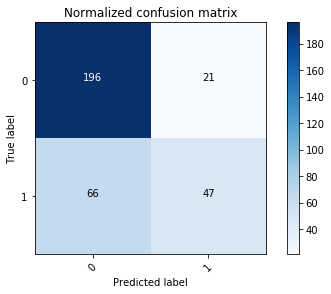

In [43]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()

In [ ]:
# TP = 47
# TN = 196
# FP = 21
# FN = 66

In [45]:
# ROC/AUC
#First calculate the probability scores of each of the datapoints:
y_test_score = model_log.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_test_score)

y_train_score = model_log.decision_function(X_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

AUC: 0.7360425757513966


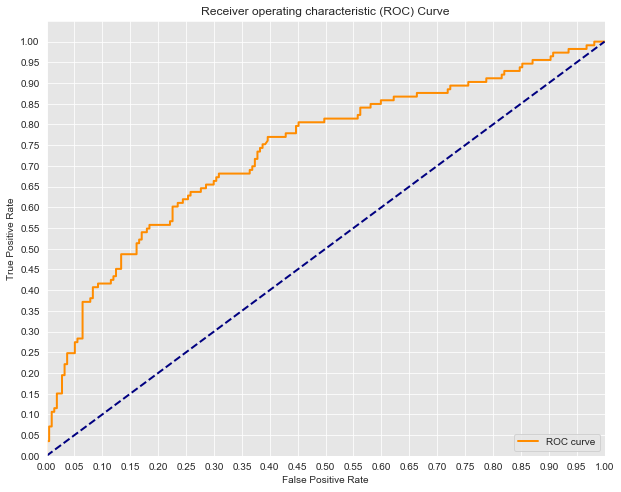

In [46]:
plot_AUC_ROC(y_test_score,fpr,tpr)

# Model 2: KNN

In [51]:
model_KNN = KNeighborsClassifier()
model_KNN.fit(X_train, y_train)
y_hat_test = model_KNN.predict(X_test)
y_hat_train = model_KNN.predict(X_train)

In [52]:
print_metrics(y_train,y_hat_train)
print("---------")
print_metrics(y_test, y_hat_test)

Precision Score: 0.7402985074626866
Recall Score: 0.5662100456621004
Accuracy Score: 0.7895136778115501
F1 Score: 0.6416558861578266
---------
Precision Score: 0.5975609756097561
Recall Score: 0.4336283185840708
Accuracy Score: 0.706060606060606
F1 Score: 0.5025641025641024


In [ ]:
# accuracy score went up for train set, but down for test set - let's try to tune our hyperparameters

In [72]:
params = {'n_neighbors': [1,3,5,7,9,11,13,15],
          'weights':['uniform','distance'],
          'metric':['euclidean','manhattan']}
gs=GridSearchCV(model_KNN,params,n_jobs=-1, verbose=1, cv=3)
gs_results= gs.fit(X_train,y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    4.0s finished


In [74]:
print(gs_results.best_params_)
print(gs_results.best_score_)

{'metric': 'manhattan', 'n_neighbors': 13, 'weights': 'uniform'}
0.7074468085106383


In [63]:
model_KNN = KNeighborsClassifier(metric='manhattan', n_neighbors=13,weights='uniform')
model_KNN.fit(X_train, y_train)
y_hat_test = model_KNN.predict(X_test)
y_hat_train = model_KNN.predict(X_train)

In [65]:
print_metrics(y_hat_test,y_test)

Precision Score: 0.34513274336283184
Recall Score: 0.609375
Accuracy Score: 0.7
F1 Score: 0.4406779661016949


[[192  25]
 [ 74  39]]


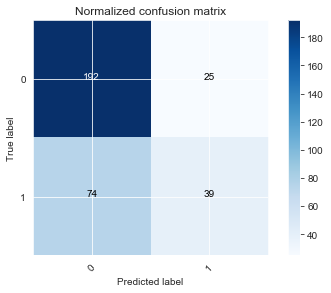

In [67]:
cnf_matrix = confusion_matrix(y_test, y_hat_test)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1],
                      title='Normalized confusion matrix')
plt.show()

# # KNN seems to perform worse than log reg, despite using grid search to optimize parameters 
# so let's move on

In [ ]:
# - weights which can be set to either ‘uniform’, where each neighbor 
# within the boundary carries the same weight or ‘distance’ where closer 
# points will be more heavily weighted toward the decision. 
# Note that when weights = 'distance' the class with the highest number in the boundary may not “win the vote”

## Model 3: Decision Tree

In [68]:
DT_clf= DecisionTreeClassifier()
DT_clf.fit(X_train,y_train) 
y_hat_test = DT_clf.predict(X_test)

In [70]:
print_metrics(y_test,y_hat_test) # pretty low accuracy score with default params, let's try gridsearch

Precision Score: 0.4519230769230769
Recall Score: 0.415929203539823
Accuracy Score: 0.6272727272727273
F1 Score: 0.43317972350230416


In [ ]:
params = {criterion='entropy',
          max_features=7, 
          max_depth=3,
          min_samples_split=0.6, 
          min_samples_leaf=0.25}
gs=GridSearchCV(DT_clf,params,n_jobs=-1, verbose=1, cv=3)
gs_results= gs.fit(X_train,y_train)

In [ ]:
gs_results.best_params_

In [ ]:
print_metrics(y_test,y_hat_test)

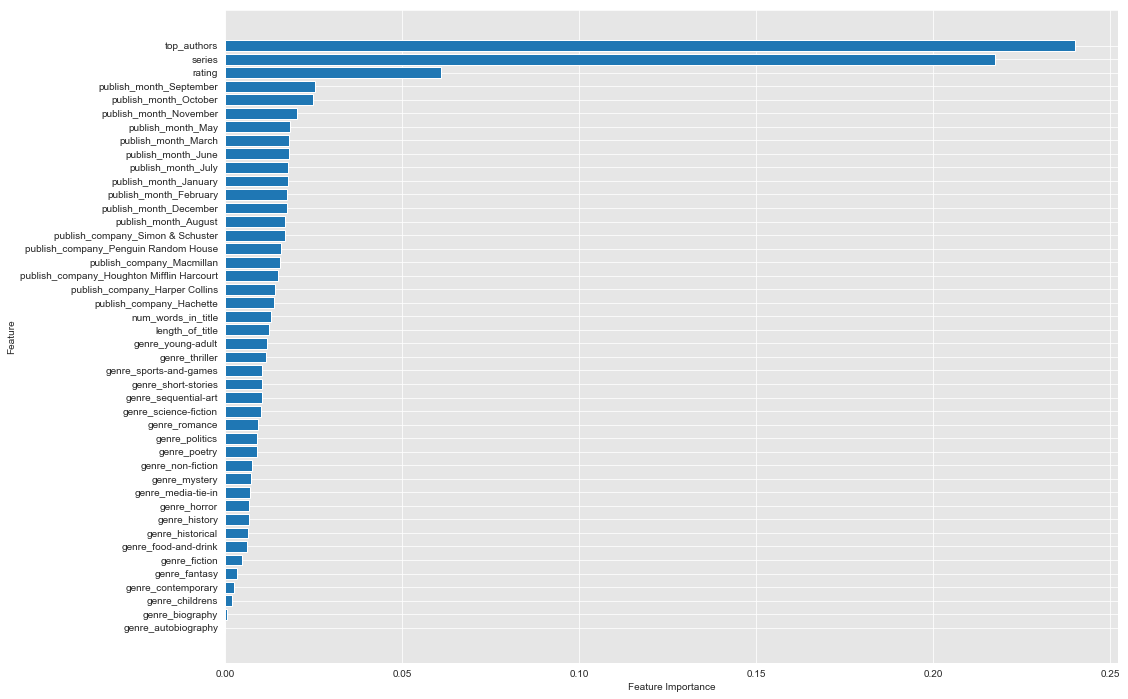

In [71]:
plot_feature_importance(DT_clf,X_train,n=44)

## Model 4: Random Forest

In [221]:
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [222]:
y_hat_test = forest.predict(X_test)

In [223]:
accuracy_score(y_hat_test,y_test)

0.7272727272727273

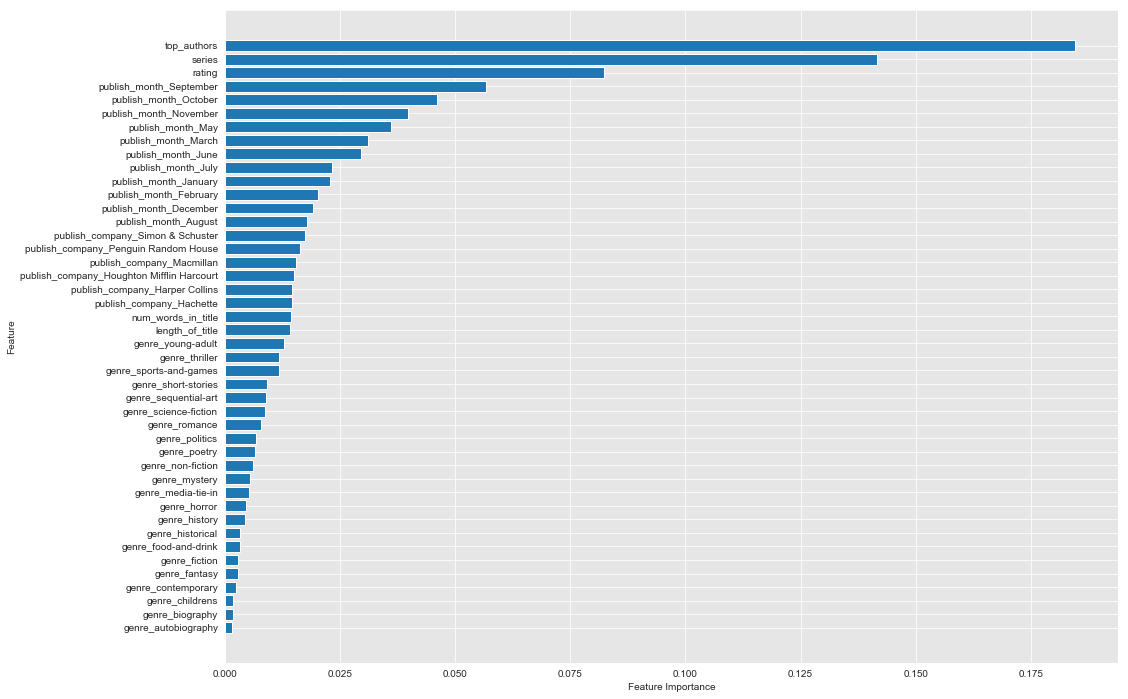

In [224]:
plot_feature_importance(forest,X_train,n=44)

In [228]:
rf_clf = RandomForestClassifier()

In [239]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 6, 10, 20, 40],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [1, 2, 5]
}


In [240]:

start = time.time()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 30, 100], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 6, 10, 20, 40], 'min_samples_split': [10, 20], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [ ]:
bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [241]:
y_hat = rf_grid_search.predict(X_test)

In [242]:
accuracy_score(y_hat,y_test)

0.7363636363636363

In [243]:
print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))

Testing Accuracy: 72.19%
Total Runtime for Grid Search on Random Forest Classifier: 60.24 seconds

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 40, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 30}


## Model 5: XGBoost

In [22]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_hat_train = clf.predict(X_train)
y_hat_test = clf.predict(X_test)
training_accuracy = accuracy_score(y_train, y_hat_train)
val_accuracy = accuracy_score(y_test, y_hat_test)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Training Accuracy: 76.29%
Validation accuracy: 73.33%


In [29]:
param_grid = {
    "learning_rate": [0.5,0.1,0.15],
    'max_depth': [4,5,6],
    'min_child_weight': [10],
    'subsample': [ 0.7],
    'n_estimators': [5, 30, 100, 250],
}

In [32]:
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=3, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 5
min_child_weight: 10
n_estimators: 30
subsample: 0.7

Training Accuracy: 72.57%
Validation accuracy: 71.52%
